In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from adan_pytorch import Adan
import numpy as np
# from utils import preparte_data_loader
# from utils import set_parameter_requires_grad
from utils import DEVICE, LOSS_CRITERIA
import time
from utils import DEVICE, AudioDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformers import HubertConfig, HubertForSequenceClassification
from madgrad import MADGRAD
torch.cuda.empty_cache()

In [4]:
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

### our training cycle - we want to train hubert from scratch to visualize the comparison between the different optimizers:

In [5]:



def train_model(model, dataloaders, optimizer, num_epochs=25, device=DEVICE, loss_criteria = LOSS_CRITERIA):
    since = time.time()

    val_acc_history = []
    training_acc = []
    training_loss = []
    val_loss = []

    # best_model_wts = copy.deepcopy(model.state_dict())
    # best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # outputs = model(inputs)
                    logits_h = model(inputs).logits.type(torch.cuda.FloatTensor)
                    labels = labels.type(torch.cuda.FloatTensor)
                    loss = loss_criteria(logits_h.view(-1), labels.view(-1))
                    # loss = loss_criteria(outputs, labels)

                    _, preds = torch.max(logits_h, 1)
                    _, real_labels = torch.max(labels, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        if type(optimizer) == MADGRAD:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                running_corrects += torch.sum(preds == real_labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss.append(epoch_loss)
            if phase == 'train':
                training_acc.append(epoch_acc)
                training_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, training_acc, val_acc_history,training_loss,val_loss

### loading audio data with batch 64:

we took a sample of the whole dataset in order to be able to train with the current resources - only the first half of the audio

we examine the data in the data preperation to section to check that we dont ruin the process by shortening the samples

we took the ecs - 10 data set but the notebook is also fine for the 50 ecs - all you need to do is to change the flag ONLY_10_LABELS in the util section and train again

In [6]:
train_dataset = AudioDataset(kind='train')
val_dataset = AudioDataset(kind='test')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

dataloaders = {
    'train':train_loader,
    'val':val_loader
}


### Hubert
we took Hubert which has big architucture and lower its dimension and parrameters - instead of couple of conv layers we saved three 

also we used less attention heads and hidden sizes

this affect the generalize capabilities of the model but improve the training dramatically

### optuna

we ran for 100 trails (or 10 minutes) on validation set for each model to gather the best configuration for each optimizer 

In [7]:

# config = HubertConfig(
#     hidden_size=128,
#     num_hidden_layers=2,
#     num_attention_heads=4,
#     intermediate_size=256,
#     num_labels=50,
#     conv_dim=(512, 512, 512),
#     conv_stride=(5, 2, 2),
#     conv_kernel=(10, 3, 3)
#     )
# hubert_model = HubertForSequenceClassification(config) 
# opt = MADGRAD(params=hubert_model.parameters(), lr=0.0019, momentum=0.934, weight_decay=0, eps= 1e-06, decouple_decay=False)


In [8]:
# 'Adam': optim.Adam(hubert_model.parameters(), lr=0.0013),
#     'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.00071, momentum=0.756, nesterov=True),
#     'Adan': Adan(hubert_model.parameters(),lr = 0.0012, betas = (0.04, 0.091, 0.072), weight_decay = 0.02),
#     'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=0.0019, momentum=0.934, weight_decay=0, eps= 1e-06, decouple_decay=False) 

In [16]:

results_metric = {
    'Adam':{
        
    },
    'SGD':{
        
    },
    'Adan':{
        
    },
    'Madgrad':{
        
    }
}

config = HubertConfig(
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=4,
    intermediate_size=256,
    num_labels=50,
    conv_dim=(512, 512, 512),
    conv_stride=(5, 2, 2),
    conv_kernel=(10, 3, 3)
    )

optimizers = ['Adan','SGD','Adam','Madgrad']

for optimizer_name in optimizers:
    hubert_model = HubertForSequenceClassification(config)   
    final_optimizer_configurations = {
    'Adam': optim.Adam(hubert_model.parameters(), lr=0.00055), #7 min
    'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.0022, momentum=0.307, nesterov=True), #11 min
    'Adan': Adan(hubert_model.parameters(),lr = 0.0024, betas = (0.082, 0.0717, 0.0783), weight_decay = 0.02), #9 min
    'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=0.00035, momentum=0.912, weight_decay=0, eps= 1e-06, decouple_decay=False)  #9 min
    }
    hubert_model = hubert_model.to(DEVICE) 
    
    model, training_acc, val_acc_history,training_loss,val_loss = train_model(hubert_model, dataloaders,
                                final_optimizer_configurations[optimizer_name], num_epochs=100, device=DEVICE, loss_criteria = LOSS_CRITERIA)
    results_metric[optimizer_name]['training_acc'] = training_acc
    results_metric[optimizer_name]['val_acc_history'] = val_acc_history
    results_metric[optimizer_name]['training_loss'] = training_loss
    results_metric[optimizer_name]['val_loss'] = val_loss
    results_metric[optimizer_name]['model'] = model
# optim.Adam(model.parameters(), lr=3e-4)
# torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# optim = Adan(model.parameters(),lr = 1e-3,                  # learning rate (can be much higher than Adam, up to 5-10x)
#     betas = (0.02, 0.08, 0.01), # beta 1-2-3 as described in paper - author says most sensitive to beta3 tuning
#     weight_decay = 0.02         # weight decay 0.02 is optimal per author
# )

Epoch 0/99
----------
train Loss: 484.0527 Acc: 0.0500
val Loss: 393.9241 Acc: 0.1000

Epoch 1/99
----------
train Loss: 420.1470 Acc: 0.1250
val Loss: 344.8619 Acc: 0.1375

Epoch 2/99
----------
train Loss: 387.0856 Acc: 0.1458
val Loss: 333.2900 Acc: 0.3125

Epoch 3/99
----------
train Loss: 372.3032 Acc: 0.2167
val Loss: 322.1728 Acc: 0.3125

Epoch 4/99
----------
train Loss: 361.1565 Acc: 0.3583
val Loss: 311.5217 Acc: 0.3375

Epoch 5/99
----------
train Loss: 349.0285 Acc: 0.3500
val Loss: 308.2334 Acc: 0.4125

Epoch 6/99
----------
train Loss: 345.5079 Acc: 0.3542
val Loss: 301.6375 Acc: 0.3000

Epoch 7/99
----------
train Loss: 335.5236 Acc: 0.4292
val Loss: 297.7388 Acc: 0.4875

Epoch 8/99
----------
train Loss: 332.2851 Acc: 0.4333
val Loss: 292.9400 Acc: 0.5750

Epoch 9/99
----------
train Loss: 334.6659 Acc: 0.5125
val Loss: 291.9341 Acc: 0.5750

Epoch 10/99
----------
train Loss: 324.7398 Acc: 0.5333
val Loss: 291.1933 Acc: 0.5750

Epoch 11/99
----------
train Loss: 325.496

In [23]:
def plot_loss_curve(results_metric, only_val=True):
    plt.figure(figsize=(10, 5))
    for opt in results_metric:
        d = results_metric[opt]
        
        if not only_val:
        
            training_loss = [i for i in d['training_loss']]#.cpu().numpy().tolist()
            plt.plot(training_loss, label=f'Train Loss {opt}')
        
        val_acc_history = [i for i in d['val_loss']]#.cpu().numpy().tolist()
        # plot_results(training_loss,val_acc_history)
        # if np.array(training_loss).mean()>1000:
        #     continue
        plt.plot(val_acc_history, label=f'Validation Loss {opt}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [24]:
def plot_accuracy_curve(results_metric, only_val=True):
    plt.figure(figsize=(10, 5))
    for opt in results_metric:
        d = results_metric[opt]
        if not only_val:
            training_loss = [i.cpu().numpy().tolist() for i in d['training_acc']]#
            plt.plot(training_loss, label=f'Train accuracy {opt}')
        val_acc_history = [i.cpu().numpy().tolist() for i in d['val_acc_history']]#.cpu().numpy().tolist()
        # plot_results(training_loss,val_acc_history)
        
        
        plt.plot(val_acc_history, label=f'Validation accuracy {opt}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [18]:
import pickle
with open('study_20240811/results_20240811.pickle', 'wb') as handle:
    pickle.dump(results_metric, handle, protocol=pickle.HIGHEST_PROTOCOL)

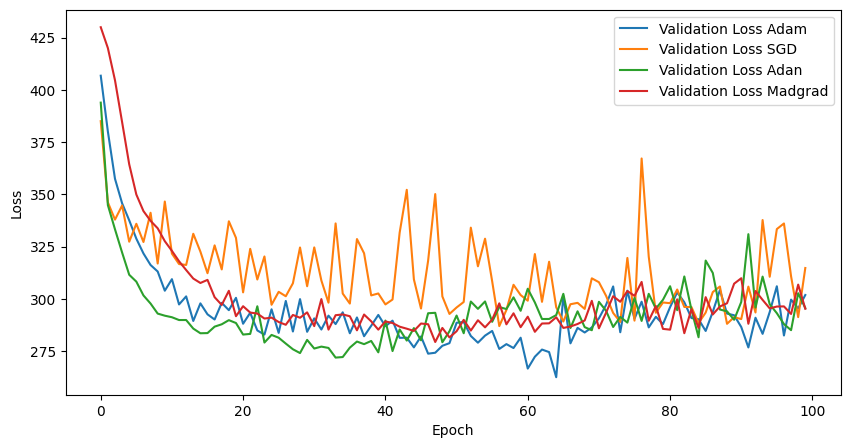

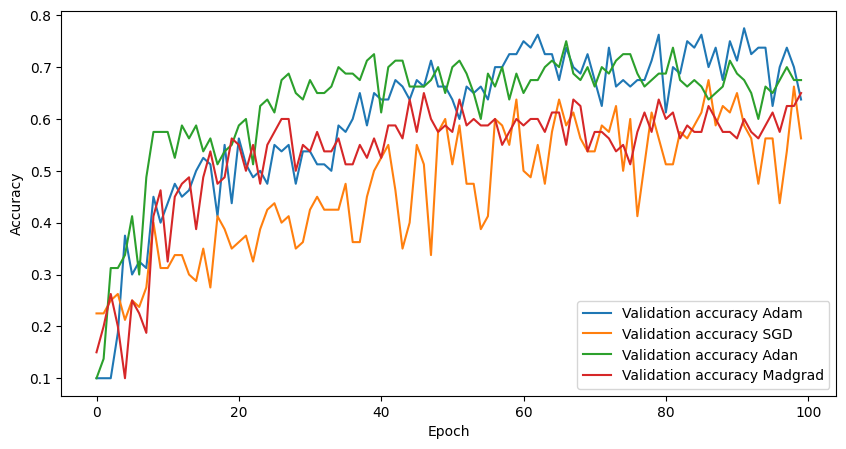

In [25]:
import pickle
with open('study_20240811/results_20240811.pickle', 'rb') as handle:
    final_results = pickle.load(handle)
# final_results['Madgrad'] = results_metric['Madgrad']
plot_loss_curve(final_results)
plot_accuracy_curve(final_results)